In [ ]:
# ==========================================================
# XAI demo: PDP, ICE, ALE for continuous, discrete, categorical
# + permutation importance + 2D PDP (interaction)
# ==========================================================
# pip install numpy pandas matplotlib scikit-learn  (if needed)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.preprocessing import OrdinalEncoder

# ------------------------
# 1) Synthetic dataset with all 3 feature types
# ------------------------
rng = np.random.RandomState(7)
n = 1800

# Continuous
sqft = np.clip(rng.normal(2100, 600, size=n), 500, 5000)
age = rng.uniform(0, 80, size=n)

# Discrete numeric (few integer values)
bathrooms = rng.choice([1, 2, 3, 4], size=n, p=[0.2, 0.5, 0.25, 0.05])

# Categorical (unordered)
neighborhood = rng.choice(["A", "B", "C"], size=n, p=[0.45, 0.35, 0.20])

# Mild correlations
sqft = sqft + (bathrooms - 2) * 200 + (neighborhood == "C") * 150
age = age + (neighborhood == "A") * 5 - (neighborhood == "C") * 3

# Outcome with nonlinearity + interactions
noise = rng.normal(0, 25_000, size=n)
base = (
    140 * sqft
    - 0.015 * np.maximum(sqft - 2700, 0) ** 2  # saturation > 2700 sqft
    - 1800 * age
    + 23_000 * bathrooms
)
nh_effect = np.select(
    [neighborhood == "A", neighborhood == "B", neighborhood == "C"],
    [-15_000, 10_000, 35_000],
)
interaction = 120 * np.maximum(sqft - 2000, 0) * (bathrooms >= 3) / 100.0
price = base + nh_effect + interaction + noise

df = pd.DataFrame(
    {"sqft": sqft, "age": age, "bathrooms": bathrooms.astype(int),
     "neighborhood": neighborhood, "price": price}
)

# Ordinal-encode the categorical for tree model input
enc = OrdinalEncoder()
df["neighborhood_enc"] = enc.fit_transform(df[["neighborhood"]]).astype(int)
cat_levels = list(enc.categories_[0])

X = df[["sqft", "age", "bathrooms", "neighborhood_enc"]]
y = df["price"]

# ------------------------
# 2) Train model
# ------------------------
model = RandomForestRegressor(
    n_estimators=500, random_state=7, min_samples_leaf=2
).fit(X, y)

print("Sample rows:\n", df.head(), "\n")

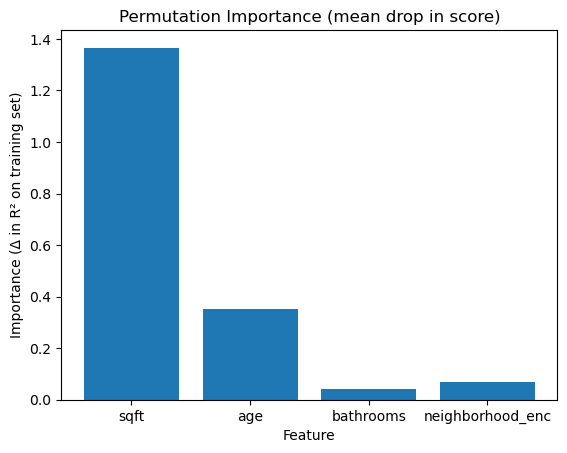

In [15]:
# ------------------------
# 3) Permutation Importance (global)
# ------------------------
imp = permutation_importance(model, X, y, n_repeats=10, random_state=7)
plt.figure()
plt.bar(X.columns, imp.importances_mean)
plt.title("Permutation Importance (mean drop in score)")
plt.xlabel("Feature")
plt.ylabel("Importance (Δ in R² on training set)")
plt.show()

In [ ]:
# ------------------------
# 4) PDP helpers (ADS-style replace-column averaging)
# ------------------------
def pdp_continuous(model, X, feature, grid=None):
    if grid is None:
        grid = np.linspace(X[feature].quantile(0.05), X[feature].quantile(0.95), 50)
    preds = []
    Xc = X.copy()
    for v in grid:
        Xc.loc[:, feature] = v
        preds.append(model.predict(Xc).mean())
    return grid, np.array(preds)

def pdp_discrete(model, X, feature):
    values = np.unique(X[feature].values)
    preds = []
    Xc = X.copy()
    for v in values:
        Xc.loc[:, feature] = v
        preds.append(model.predict(Xc).mean())
    return values, np.array(preds)

def pdp_categorical(model, X, feature_enc, cat_levels):
    Xc = X.copy()
    int_levels = np.arange(len(cat_levels))
    preds = []
    for i in int_levels:
        Xc.loc[:, feature_enc] = i
        preds.append(model.predict(Xc).mean())
    return int_levels, np.array(preds)

# ------------------------
# 5) ICE helpers
# ------------------------
def ice_continuous(model, X, feature, grid=None, sample=120, random_state=7):
    rng = np.random.RandomState(random_state)
    idx = rng.choice(np.arange(X.shape[0]), size=min(sample, X.shape[0]), replace=False)
    Xsub = X.iloc[idx].copy()
    if grid is None:
        grid = np.linspace(X[feature].quantile(0.05), X[feature].quantile(0.95), 35)
    curves = []
    for i in range(Xsub.shape[0]):
        Xi = pd.DataFrame(np.repeat(Xsub.iloc[i].values.reshape(1, -1), len(grid), axis=0), columns=X.columns)
        Xi.loc[:, feature] = grid
        curves.append(model.predict(Xi))
    return grid, np.array(curves)

def ice_discrete(model, X, feature, sample=120, random_state=7):
    rng = np.random.RandomState(random_state)
    idx = rng.choice(np.arange(X.shape[0]), size=min(sample, X.shape[0]), replace=False)
    Xsub = X.iloc[idx].copy()
    values = np.unique(X[feature].values)
    curves = []
    for i in range(Xsub.shape[0]):
        Xi = pd.DataFrame(np.repeat(Xsub.iloc[i].values.reshape(1, -1), len(values), axis=0), columns=X.columns)
        for j, v in enumerate(values):
            Xi.loc[j, feature] = v
        curves.append(model.predict(Xi))
    return values, np.array(curves)

def ice_categorical(model, X, feature_enc, sample=120, random_state=7, n_levels=None):
    rng = np.random.RandomState(random_state)
    idx = rng.choice(np.arange(X.shape[0]), size=min(sample, X.shape[0]), replace=False)
    Xsub = X.iloc[idx].copy()
    if n_levels is None:
        n_levels = int(X[feature_enc].max() + 1)
    levels = np.arange(n_levels)
    curves = []
    for i in range(Xsub.shape[0]):
        Xi = pd.DataFrame(np.repeat(Xsub.iloc[i].values.reshape(1, -1), len(levels), axis=0), columns=X.columns)
        for j, lv in enumerate(levels):
            Xi.loc[j, feature_enc] = lv
        curves.append(model.predict(Xi))
    return levels, np.array(curves)

# ------------------------
# 6) ALE helpers
# ------------------------
def ale_1d_continuous(model, X, feature, K=20):
    x = X[feature].values
    qs = np.quantile(x, np.linspace(0, 1, K + 1))
    for i in range(1, len(qs)):
        if qs[i] <= qs[i-1]:
            qs[i] = qs[i-1] + 1e-6

    local_effects = np.zeros(K)
    counts = np.zeros(K)
    for k in range(K):
        lo, hi = qs[k], qs[k+1]
        if k < K-1:
            idx = np.where((x >= lo) & (x < hi))[0]
        else:
            idx = np.where((x >= lo) & (x <= hi))[0]
        if idx.size == 0:
            continue
        Xlo = X.iloc[idx].copy(); Xhi = X.iloc[idx].copy()
        Xlo.loc[:, feature] = lo;  Xhi.loc[:, feature] = hi
        diffs = model.predict(Xhi) - model.predict(Xlo)
        local_effects[k] = diffs.mean()
        counts[k] = idx.size

    ale = np.cumsum(local_effects)
    ale_centered = ale - np.average(ale, weights=np.maximum(counts, 1))
    mids = 0.5 * (qs[:-1] + qs[1:])
    return mids, ale_centered

def ale_1d_discrete(model, X, feature):
    values = np.sort(np.unique(X[feature].values))
    local_effects = []
    Xc = X.copy()
    for i in range(len(values)-1):
        v_lo, v_hi = values[i], values[i+1]
        Xlo = Xc.copy(); Xhi = Xc.copy()
        Xlo.loc[:, feature] = v_lo
        Xhi.loc[:, feature] = v_hi
        diff = (model.predict(Xhi) - model.predict(Xlo)).mean()
        local_effects.append(diff)
    ale = np.cumsum(local_effects)
    ale_centered = ale - np.mean(ale)
    mids = (values[:-1] + values[1:]) / 2.0
    return values, mids, ale_centered

def ale_categorical(model, X, feature_enc, n_levels):
    Xc = X.copy()
    means = []
    for lv in range(n_levels):
        Xc.loc[:, feature_enc] = lv
        means.append(model.predict(Xc).mean())
    means = np.array(means)
    centered = means - means.mean()
    return np.arange(n_levels), centered

# ------------------------
# 7) PDP plots (continuous, discrete, categorical)
# ------------------------
grid, pdp_vals = pdp_continuous(model, X, "sqft")
plt.figure(); plt.plot(grid, pdp_vals); plt.title("PDP — Continuous (sqft)")
plt.xlabel("sqft"); plt.ylabel("Avg prediction"); plt.show()

vals_d, pdp_d = pdp_discrete(model, X, "bathrooms")
plt.figure(); plt.plot(vals_d, pdp_d, marker="o"); plt.title("PDP — Discrete (bathrooms)")
plt.xlabel("bathrooms"); plt.ylabel("Avg prediction"); plt.show()

levels_c, pdp_c = pdp_categorical(model, X, "neighborhood_enc", cat_levels)
plt.figure(); plt.bar(levels_c, pdp_c); plt.title("PDP — Categorical (neighborhood)")
plt.xlabel("category"); plt.ylabel("Avg prediction")
plt.xticks(levels_c, cat_levels); plt.show()

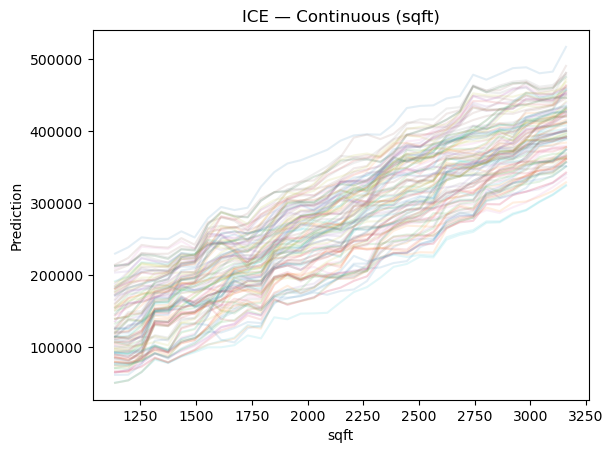

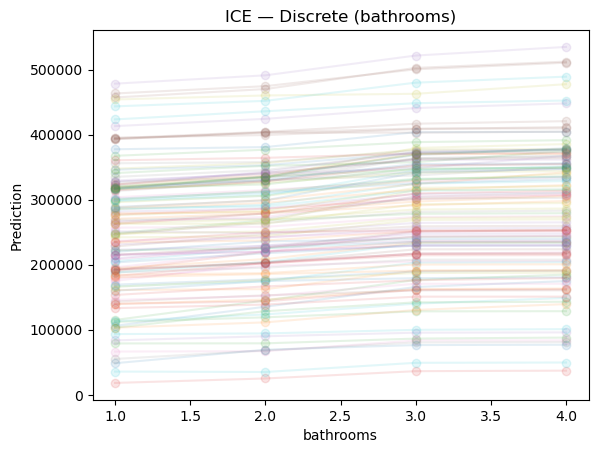

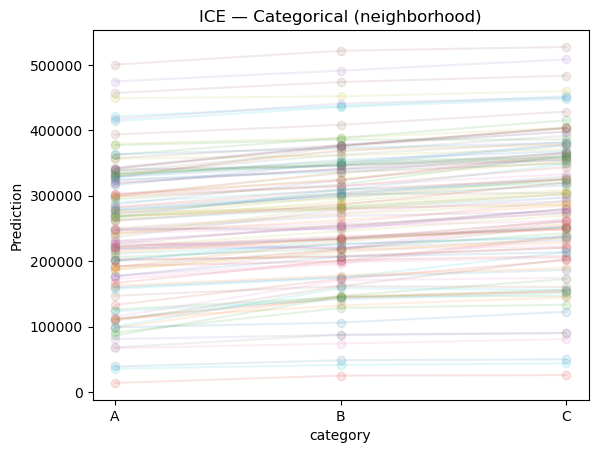

In [16]:
# ------------------------
# 8) ICE plots (continuous, discrete, categorical)
# ------------------------
grid, curves = ice_continuous(model, X, "sqft", grid=None, sample=120)
plt.figure()
for i in range(curves.shape[0]):
    plt.plot(grid, curves[i], alpha=0.12)
plt.title("ICE — Continuous (sqft)")
plt.xlabel("sqft"); plt.ylabel("Prediction"); plt.show()

dvals, dcurves = ice_discrete(model, X, "bathrooms", sample=120)
plt.figure()
for i in range(dcurves.shape[0]):
    plt.plot(dvals, dcurves[i], alpha=0.12, marker="o")
plt.title("ICE — Discrete (bathrooms)")
plt.xlabel("bathrooms"); plt.ylabel("Prediction"); plt.show()

levels, ccurves = ice_categorical(model, X, "neighborhood_enc", sample=120, n_levels=len(cat_levels))
plt.figure()
for i in range(ccurves.shape[0]):
    plt.plot(levels, ccurves[i], alpha=0.12, marker="o")
plt.title("ICE — Categorical (neighborhood)")
plt.xlabel("category"); plt.ylabel("Prediction")
plt.xticks(levels, cat_levels); plt.show()

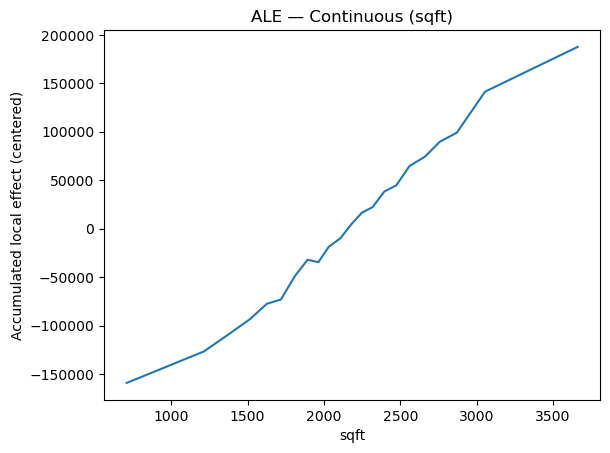

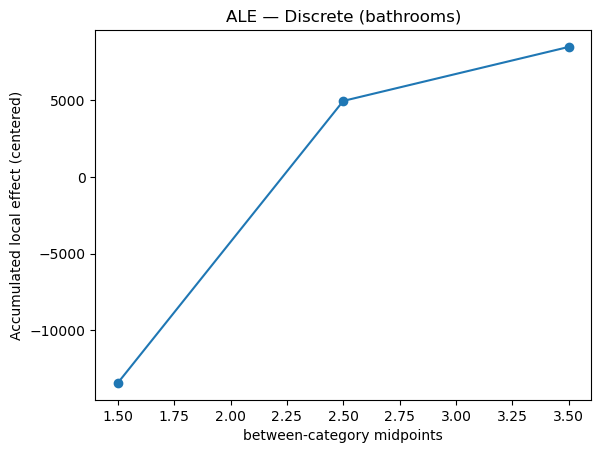

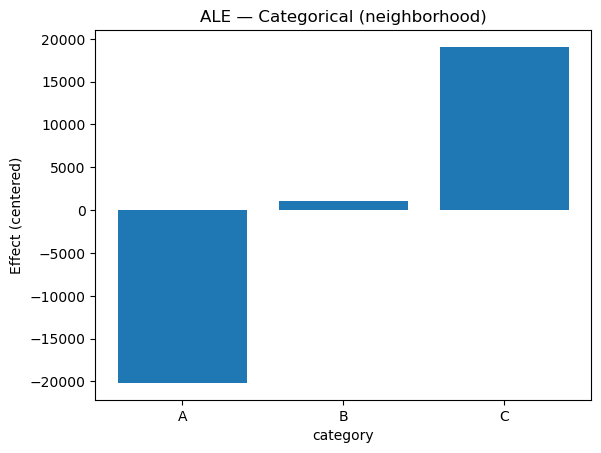

C:\Users\ytian\miniconda3\envs\localds2\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 2 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


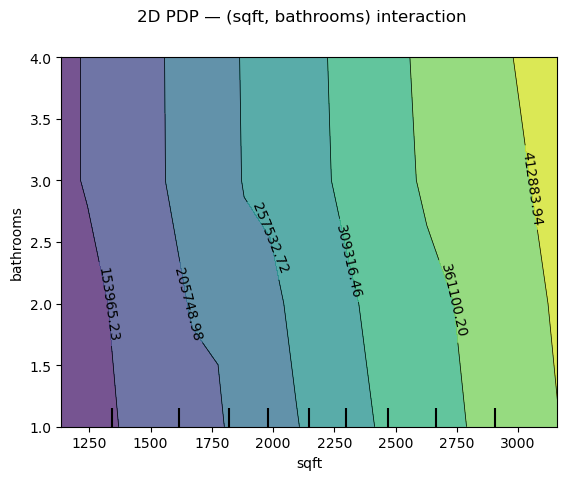

In [17]:
# ------------------------
# 9) ALE plots (continuous, discrete, categorical)
# ------------------------
mids, ale_vals = ale_1d_continuous(model, X, "sqft", K=22)
plt.figure(); plt.plot(mids, ale_vals); plt.title("ALE — Continuous (sqft)")
plt.xlabel("sqft"); plt.ylabel("Accumulated local effect (centered)"); plt.show()

values, mids_d, ale_d = ale_1d_discrete(model, X, "bathrooms")
plt.figure(); plt.plot(mids_d, ale_d, marker="o"); plt.title("ALE — Discrete (bathrooms)")
plt.xlabel("between-category midpoints"); plt.ylabel("Accumulated local effect (centered)"); plt.show()

levels_cat, ale_cat = ale_categorical(model, X, "neighborhood_enc", len(cat_levels))
plt.figure(); plt.bar(levels_cat, ale_cat); plt.title("ALE — Categorical (neighborhood)")
plt.xlabel("category"); plt.ylabel("Effect (centered)")
plt.xticks(levels_cat, cat_levels); plt.show()

# ------------------------
# 10) (Bonus) 2D PDP interaction: sqft × bathrooms
# ------------------------
PartialDependenceDisplay.from_estimator(
    model, X, features=[("sqft", "bathrooms")], kind="average", grid_resolution=20
)
plt.suptitle("2D PDP — (sqft, bathrooms) interaction")
plt.show()

# 🔍 ICE (Individual Conditional Expectation) – Behind the Scenes

Let’s say we want to explain how the feature **Age** affects a model’s prediction.

---

### 🧩 Step 1. Definitions

| Symbol | Meaning |
|---------|----------|
| **N** | Number of distinct feature values (grid points) sampled from the feature’s distribution |
| **M** | Number of samples (rows) in your dataset |
| **2M** | Two sets of arrays per sample (feature values + corresponding predictions) used to plot ICE lines |

---

### 🧠 Step 2. Setup example

- Dataset: **M = 3** rows  
- Feature grid for `Age`: **N = 4** values → `[20, 30, 40, 50]`

| ID | Age | Income | Balance |
|----|-----|---------|----------|
| 1 | 25 | 60k | 3k |
| 2 | 35 | 90k | 5k |
| 3 | 55 | 40k | 1k |

---

### ⚙️ Step 3. ADS ICE algorithm (conceptually)

For each **feature value** in the grid (`20, 30, 40, 50`):

1. Replace **Age** in all rows with that fixed value  
2. Predict using the trained model  
3. Collect all predictions (M = 3 per value)

---

### 📊 Step 4. Resulting predictions table

| Feature value (Age) | Predictions for each row (M = 3) |
|----------------------|----------------------------------|
| 20 | [0.10, 0.04, 0.02] |
| 30 | [0.20, 0.10, 0.05] |
| 40 | [0.30, 0.18, 0.09] |
| 50 | [0.45, 0.25, 0.14] |

---

### 🎨 Step 5. ADS organizes this into ICE curves

Each sample now has **2 arrays**:
- X-axis: the **N** feature values (e.g. `[20, 30, 40, 50]`)
- Y-axis: the **N** predicted outputs for that sample

So for **M = 3** samples:



feature_to_explain = "feat_2"

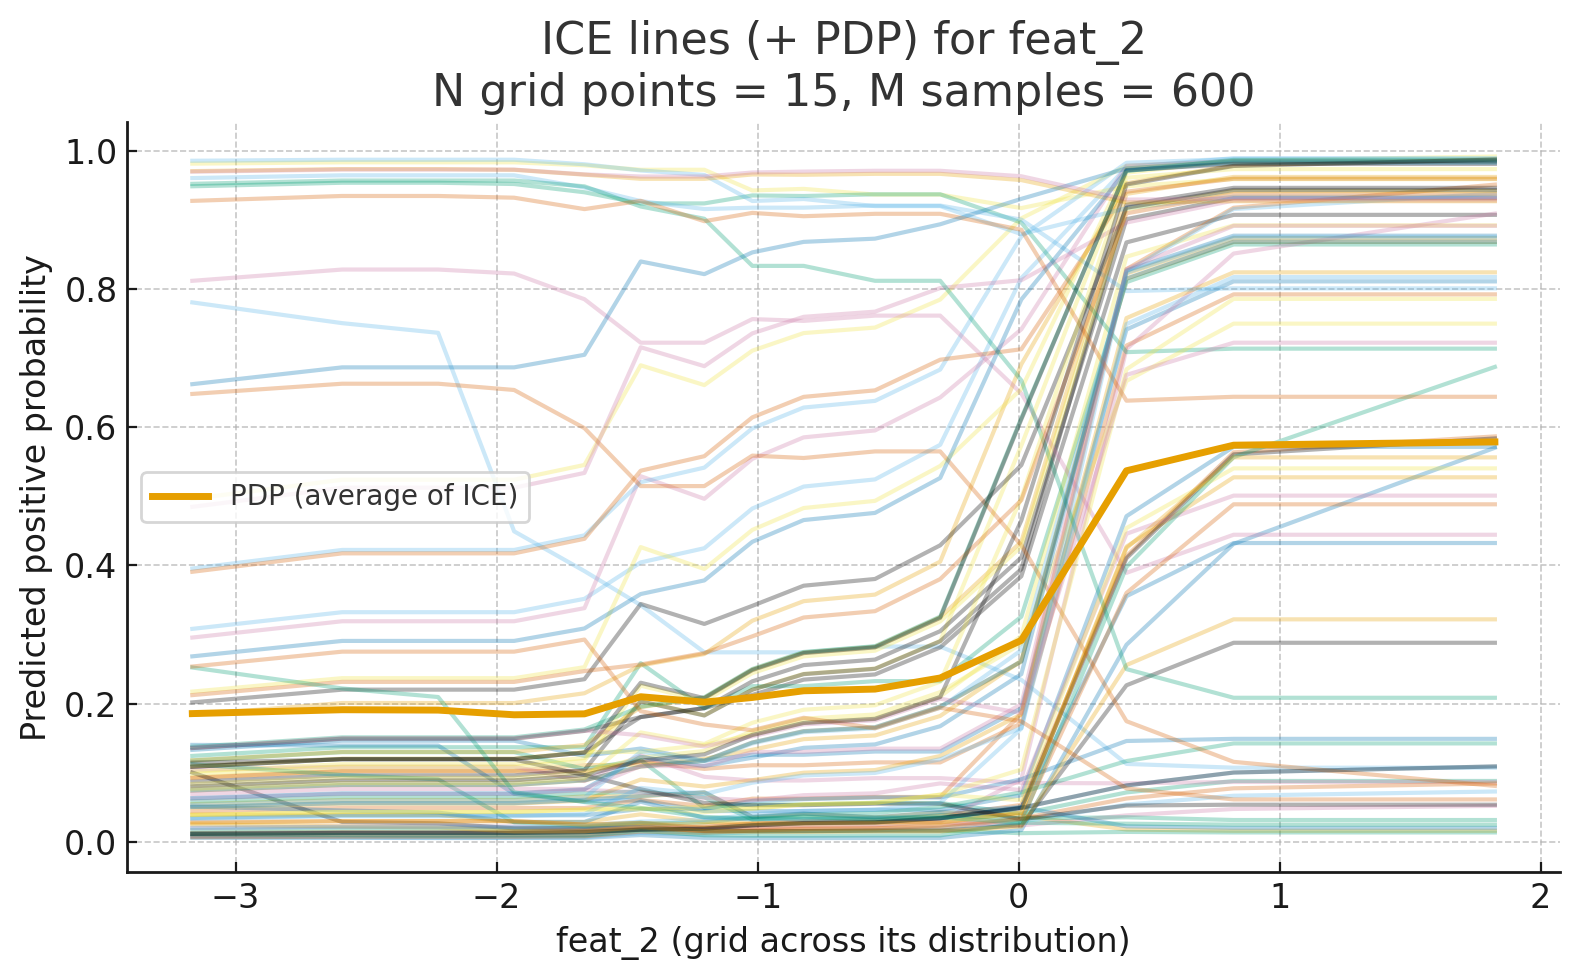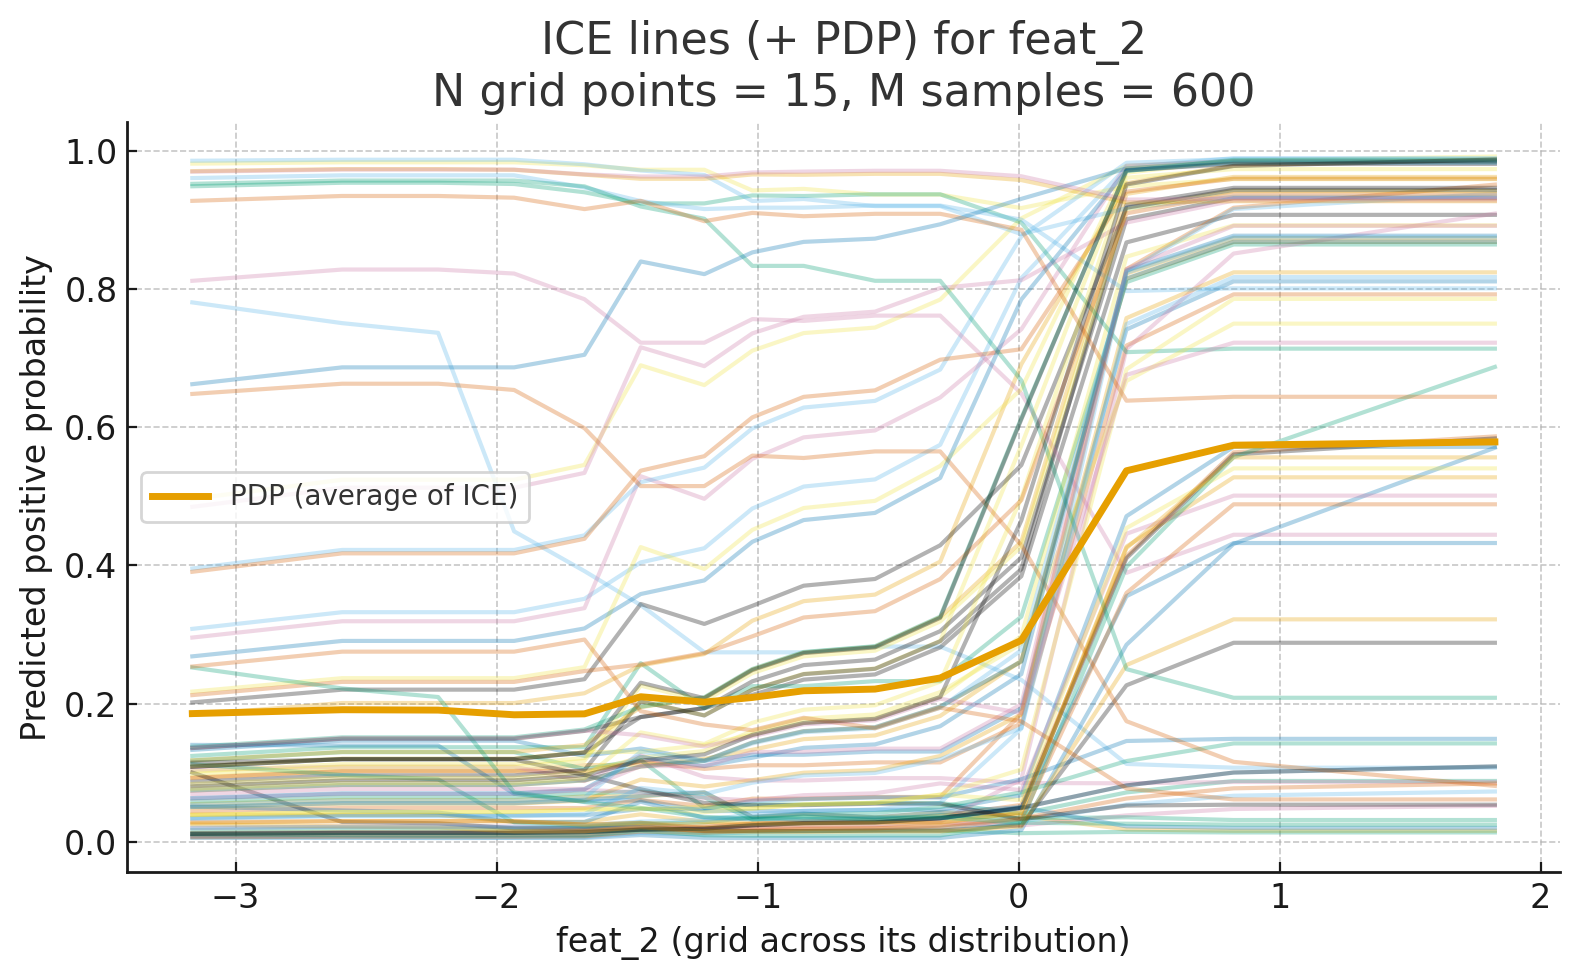

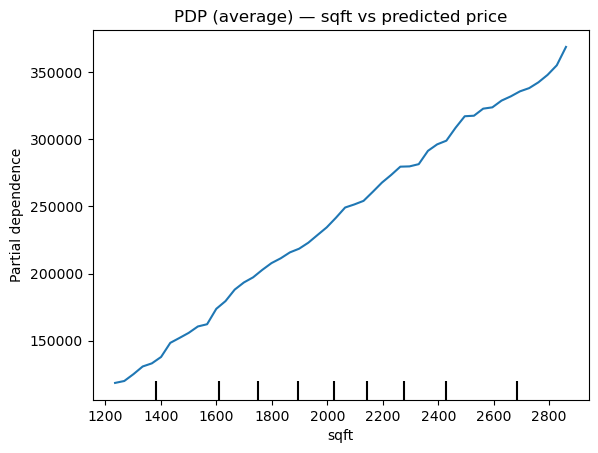

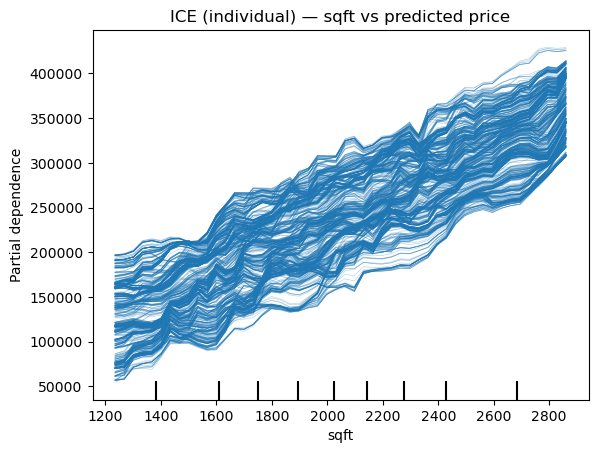

In [8]:
# ------------------------
# 5) PDP (average) and ICE (individual) for sqft
# ------------------------
PartialDependenceDisplay.from_estimator(
    model, X, features=["sqft"], kind="average", grid_resolution=50
)
plt.title("PDP (average) — sqft vs predicted price")
plt.show()

PartialDependenceDisplay.from_estimator(
    model, X, features=["sqft"], kind="individual", grid_resolution=50
)
plt.title("ICE (individual) — sqft vs predicted price")
plt.show()

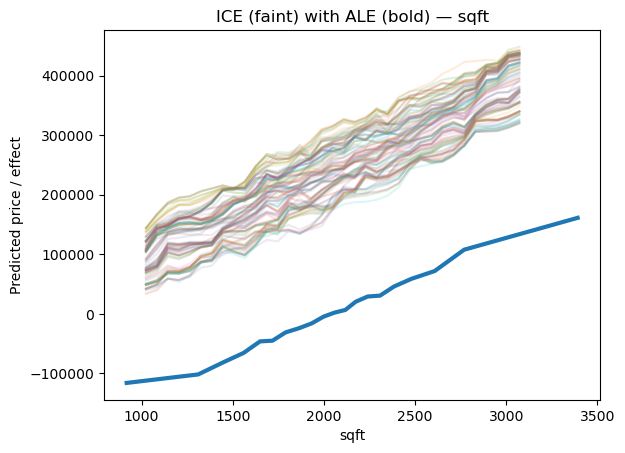

In [11]:
# ------------------------
# 7) ICE + ALE overlay for sqft (single chart)
# ------------------------
grid = np.linspace(X["sqft"].quantile(0.02), X["sqft"].quantile(0.98), 35)
subset_idx = rng.choice(np.arange(len(X)), size=120, replace=False)
X_subset = X.iloc[subset_idx].copy()

plt.figure()
for i in range(X_subset.shape[0]):
    xi = pd.DataFrame(
        np.repeat(X_subset.iloc[i].values.reshape(1, -1), len(grid), axis=0),
        columns=X.columns
    )
    xi["sqft"] = grid
    yi = model.predict(xi)
    plt.plot(grid, yi, alpha=0.15)

# overlay ALE (bold by linewidth)
plt.plot(mids, ale_vals, linewidth=3)
plt.title("ICE (faint) with ALE (bold) — sqft")
plt.xlabel("sqft")
plt.ylabel("Predicted price / effect")
plt.show()